In [269]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.integrate import solve_ivp

In [270]:
motor_max_torque = 1.1 #N*m, from salto after gearing
motor_max_vel = 25 #rad/s, 825kv motor geared 38.3
motor_I = 0.00000256 #kg*m^2
def get_motor_torque(t, motor_vel):
    input = 0*t + 1 # replace with better function of t
    return motor_max_torque * (input - motor_vel/motor_max_vel)

In [374]:
total_mass = 0.101 #kg
g = 9.81

def jump_model(t, s, k, get_TSA_mult, get_link_mult): #k is spring constant in N/m
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    TSA_mult = get_TSA_mult(motor_pos)
    link_mult = get_link_mult(foot_pos)

    spring_pos = -motor_pos/TSA_mult + foot_pos/link_mult

    motor_torque = get_motor_torque(t, dmotor_pos)

    spring_force = -k * spring_pos

    motor_net_torque = motor_torque - spring_force/TSA_mult
    ddmotor_pos = motor_net_torque / motor_I

    foot_applied_force = spring_force*link_mult
    ddfoot_pos = (foot_applied_force - total_mass*g) / total_mass

    if foot_pos <= 0: ddfoot_pos = max(ddfoot_pos, 0)

    return [dmotor_pos, ddmotor_pos, dfoot_pos, ddfoot_pos]

In [375]:
max_extension = 0.15 #m
def liftoff(t, s, k, get_TSA_mult, get_link_mult):
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state
    return foot_pos - max_extension
liftoff.terminal = True

In [402]:
def solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot):
    t_span = (0, 1)
    s0 = (0, 0, 0, 0)
    solution = solve_ivp(jump_model, t_span, s0, events=[liftoff], args=(k, get_TSA_mult, get_link_mult))

    motor_pos_data = solution.y[0, :]
    motor_vel_data = solution.y[1, :]
    foot_pos_data = solution.y[2, :]
    foot_vel_data = solution.y[3, :]



    if doPlot:
        

        TSA_mult_data = np.vectorize(get_TSA_mult)(motor_pos_data)
        link_mult_data = np.vectorize(get_link_mult)(foot_pos_data)

        spring_pos_data = -motor_pos_data/TSA_mult_data + foot_pos_data/link_mult_data

        plt.figure()
        plt.plot(solution.t, motor_pos_data/max(abs(motor_pos_data)), 'o', markersize=1, label=f"motor_pos {max(abs(motor_pos_data)}")
        plt.plot(solution.t, motor_vel_data/max(abs(motor_vel_data)), label='motor_vel')
        plt.plot(solution.t, foot_pos_data/max(abs(foot_pos_data)), label='foot_pos')
        plt.plot(solution.t, foot_vel_data/max(abs(foot_vel_data)), label='foot_vel')

        plt.plot(solution.t, spring_pos_data/abs(min(spring_pos_data)), label='spring_pos')

        plt.plot(solution.t, np.zeros_like(solution.t), 'k')
        plt.legend()

        plt.xlabel(f"time(s) {len(solution.t)} samples")
        plt.ylabel("normalized value")
        plt.title(f"end foot vel is {foot_vel_data[-1]}")

    return foot_vel_data[-1]


0.5292612763817377

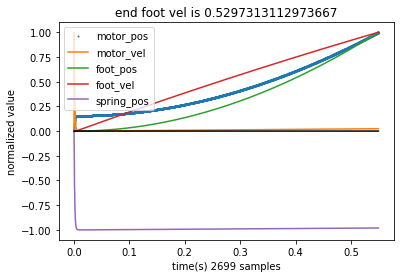

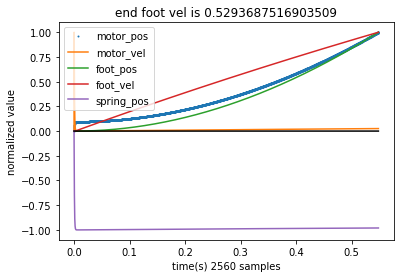

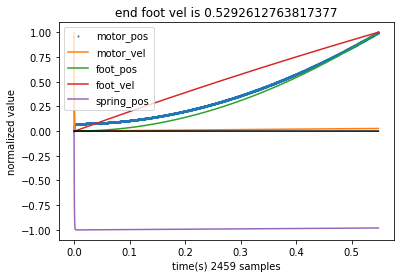

In [406]:
get_TSA_mult = lambda motor_pos: 0.01*motor_pos+1
get_link_mult = lambda foot_pos: 1

solve_end_vel(40, get_TSA_mult, get_link_mult, True) 
solve_end_vel(70, get_TSA_mult, get_link_mult, True) 
solve_end_vel(90, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(5, get_TSA_mult, get_link_mult, True) 


[1.221195374520773, 2.347641131675986, 2.6720643929900025, 2.8336772004690816, 2.920157744530046, 2.9638536179297157, 2.9806441029372555, 2.9796035815916118, 2.9664373341477903, 2.9449720119654517, 2.917893998919311, 2.887153486582702, 2.854194685228537, 2.820104125848935, 2.7857029264014956, 2.7516129645748215, 2.718298985320492, 2.6861055345029965, 2.6552773158139336, 2.625982772320771]


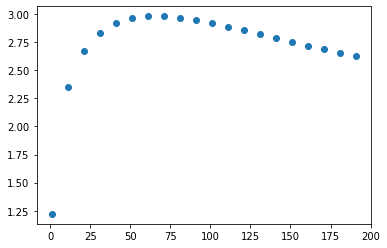

In [398]:
test_ks = np.arange(1, 200, 10)
end_vels = []

for i in test_ks:
    end_vel = solve_end_vel(k = i, get_TSA_mult=lambda x:10, get_link_mult=lambda x:1, doPlot=False)
    end_vels.append(end_vel)

print(end_vels)
plt.plot(test_ks, end_vels, 'o')

#TODO: what's the optimal MA profile? make function where input is MA profile and output is max vel (try diff k).